In [1]:
import pandas as pd
import numpy as np
import arima
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
df = pd.read_csv("data/pars_t_daily_spy.csv", index_col=0)
df.head()


,df,mu,sigma
2021-12-01,6.020063,-0.000050,0.000445
2021-12-02,5.926677,0.000033,0.000532
2021-12-03,5.988445,-0.000023,0.000583
2021-12-06,5.940078,0.000022,0.000343
2021-12-07,5.950183,0.000013,0.000186


In [3]:
# Check for stationarity
arima.adf_check(df["mu"])
arima.adf_check(df["sigma"])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.896878964824418
p-value : 4.287351451313724e-12
Number of Lags Used : 0
Number of Observations Used : 68
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.147557497318006
p-value : 0.02322811351606993
Number of Lags Used : 0
Number of Observations Used : 68
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [4]:
idx = int(len(df)*0.8)
train, test = df.iloc[:idx], df.iloc[idx:]
train.head(), test.head()

(                  df        mu     sigma
 2021-12-01  6.020063 -0.000050  0.000445
 2021-12-02  5.926677  0.000033  0.000532
 2021-12-03  5.988445 -0.000023  0.000583
 2021-12-06  5.940078  0.000022  0.000343
 2021-12-07  5.950183  0.000013  0.000186,
                   df        mu     sigma
 2022-02-18  5.984790 -0.000019  0.000474
 2022-02-22  5.992896 -0.000026  0.000582
 2022-02-23  6.046071 -0.000073  0.000506
 2022-02-24  5.862764  0.000090  0.000820
 2022-02-25  5.908596  0.000050  0.000518)

In [5]:
pd.DataFrame(df.mu)

,mu
2021-12-01,-0.000050
2021-12-02,0.000033
2021-12-03,-0.000023
2021-12-06,0.000022
2021-12-07,0.000013
...,...
2022-03-04,-0.000015
2022-03-07,-0.000066
2022-03-08,-0.000055
2022-03-09,0.000037


=================== df ===================
Best p and q based on BIC: p=5, q=2


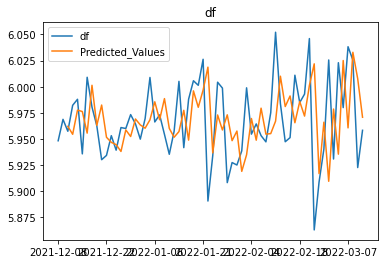

=================== mu ===================
Best p and q based on BIC: p=1, q=1


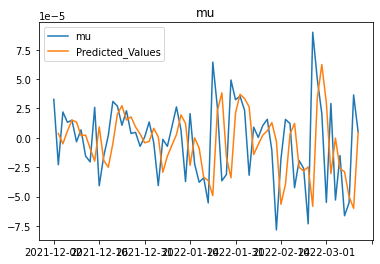

=================== sigma ===================
Best p and q based on BIC: p=1, q=1


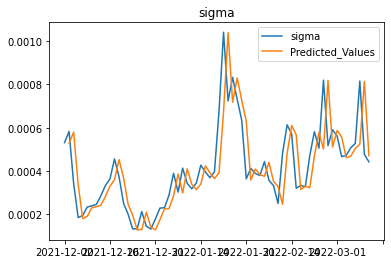

{'df': {'data':                   df  Shifted_values_1  Shifted_values_2  Shifted_values_3  \
  2021-12-08  5.948171          5.950183          5.940078          5.988445   
  2021-12-09  5.968690          5.948171          5.950183          5.940078   
  2021-12-10  5.957266          5.968690          5.948171          5.950183   
  2021-12-13  5.982145          5.957266          5.968690          5.948171   
  2021-12-14  5.987903          5.982145          5.957266          5.968690   
  ...              ...               ...               ...               ...   
  2022-03-04  5.979936          6.022954          5.930713          6.025568   
  2022-03-07  6.038268          5.979936          6.022954          5.930713   
  2022-03-08  6.025504          6.038268          5.979936          6.022954   
  2022-03-09  5.922507          6.025504          6.038268          5.979936   
  2022-03-10  5.958190          5.922507          6.025504          6.038268   
  
              Shifted_v

In [12]:
res = {}
for par in df.columns:
    print(f"=================== {par} ===================")
    results = arima.arima(1, 10, 1, 10, pd.DataFrame(df[par]), par, "BIC")
    results["data"][[par,'Predicted_Values']].plot()
    res[par] = results
    plt.title(par)
    plt.xticks(rotation = 45)
    plt.show()

In [8]:
inter_day = pd.read_csv("data/SPY_minute.csv", index_col=0)
inter_day.columns = inter_day.iloc[0]
inter_day = inter_day[1:]
inter_day.head(10)

Dates,Close,Volume
SPY US Equity,,
#NAME?,461.27,818361
12/1/21 9:31,460.81,348832
12/1/21 9:32,460.69,331253
12/1/21 9:33,460.76,271748
12/1/21 9:34,460.29,255663
12/1/21 9:35,460.49,287824
12/1/21 9:36,460.53,247480
12/1/21 9:37,460.63,178755
12/1/21 9:38,460.57,235893


In [9]:
inter_day["log"] = np.log(inter_day["Close"].astype(float))
inter_day["deltas"] = inter_day["log"].diff()
inter_day.head(10)

Dates,Close,Volume,log,deltas
SPY US Equity,,,,
#NAME?,461.27,818361,6.133984,NaN
12/1/21 9:31,460.81,348832,6.132986,-0.000998
12/1/21 9:32,460.69,331253,6.132725,-0.000260
12/1/21 9:33,460.76,271748,6.132877,0.000152
12/1/21 9:34,460.29,255663,6.131857,-0.001021
12/1/21 9:35,460.49,287824,6.132291,0.000434
12/1/21 9:36,460.53,247480,6.132378,0.000087
12/1/21 9:37,460.63,178755,6.132595,0.000217
12/1/21 9:38,460.57,235893,6.132465,-0.000130


In [10]:
samples = inter_day.deltas
samples = samples.dropna().tolist()
samples

[-0.0009977443132065389,
 -0.00026044492822130394,
 0.00015193445142891449,
 -0.001020574433082011,
 0.00043441430775104095,
 8.68602202448443e-05,
 0.000217117548293011,
 -0.00013026487209000237,
 -0.0002605806620463724,
 0.0006730278909294896,
 0.00041227718629777144,
 0.0,
 -2.1694562259533257e-05,
 0.0,
 0.0010841519741857653,
 -4.3343519067207126e-05,
 -0.0003403118980527253,
 -0.00024500955768225197,
 -0.0007592603000459164,
 -4.340371970634749e-05,
 0.00043395244562294266,
 -0.00017355838113619626,
 0.000629005866155552,
 -0.0005422229102736154,
 0.0004771716824087946,
 -0.0001734906319414975,
 0.0005962479917771546,
 0.0004225787115723634,
 2.1665890305833102e-05,
 0.0007580105834703588,
 0.0008309854146855145,
 0.0005968445267479083,
 -0.0004973456979397994,
 -0.0002379484528356457,
 0.0004325914457616875,
 -0.0004325914457616875,
 0.0004974640252264351,
 0.000562052804523816,
 0.0003025130211709026,
 0.0001296204283605107,
 -0.00015122546665669034,
 -8.642482126219875e-05,
 -

In [11]:
kstest(samples, lambda x: norm.cdf(x,loc=mu_hat, scale=sigma_hat))

NameError: name 'mu_hat' is not defined